In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sys
sys.path.append("../src/")
from tapm import model_HIVandSTI
from tapm import utils
import icomo
import diffrax
import numpy as np

INFO:jax._src.xla_bridge:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


In [2]:
#output = integrator(y0=y0, constant_args=args)
output = icomo.diffeqsolve(
    args = model_HIVandSTI.args,
    ODE = model_HIVandSTI.main_model,
    y0 = model_HIVandSTI.y0,
    ts_out = np.linspace(0, 365*20, 365*20+1),
    max_steps=365*20+1)

INFO:tapm.HIVandSTI.model_HIVandSTI:Using exponential function to calculate m
INFO:tapm.HIVandSTI.model_HIVandSTI:Parameters: m_min = 0.0, m_max = 1


In [3]:
def n_observed(args=model_HIVandSTI.args, y=output):
    out = args["lambda_s"]*jnp.sum(jnp.array([y["Is1_STI"], y["Is2_STI"], y["Is3_STI"], y["Is4_STI"]]))+model_HIVandSTI.lambda_a(args=args, y=y)*jnp.sum(jnp.array([y["Ia1_STI"], y["Ia2_STI"], y["Ia3_STI"], y["Ia4_STI"]]))
    return out

A1 [0.0012093  0.0009787  0.00035113 0.00020873]
A2 [0.03424924 0.02708104 0.00962825 0.00554706]
A3 [0.00186756 0.0014776  0.00052546 0.00030299]
A4 [0.00234925 0.00185814 0.00066071 0.00038081]
D [0.0294969  0.02322547 0.00824375 0.00472163]
D_STI [0.0294969  0.02322547 0.00824375 0.00472163]
I1 [2.86363819e-05 2.52635461e-05 9.35155996e-06 6.14153895e-06]
I2 [0.00433599 0.00346455 0.00123684 0.00072291]
I3 [5.17175293e-04 4.12385274e-04 1.47102908e-04 8.57370604e-05]
I4 [5.08629693e-04 4.04648398e-04 1.44214022e-04 8.37907980e-05]
IP [1.09796663e-05 1.00297398e-05 3.75600903e-06 2.55182341e-06]
Ia_STI [0.07184942 0.05321248 0.01875858 0.01161094]
Is_STI [0.00085084 0.000633   0.00022595 0.00014597]
S [0.14617968 0.11419109 0.04040424 0.02288539]
SP [0.23024666 0.17987108 0.06364518 0.03605226]
S_STI [0.3469561  0.27455048 0.09727407 0.05419017]
T_STI [0.00184674 0.00137857 0.00049765 0.00033129]
HIV sum at start [Array(0.451, dtype=float64, weak_type=True), Array(0.353, dtype=float6

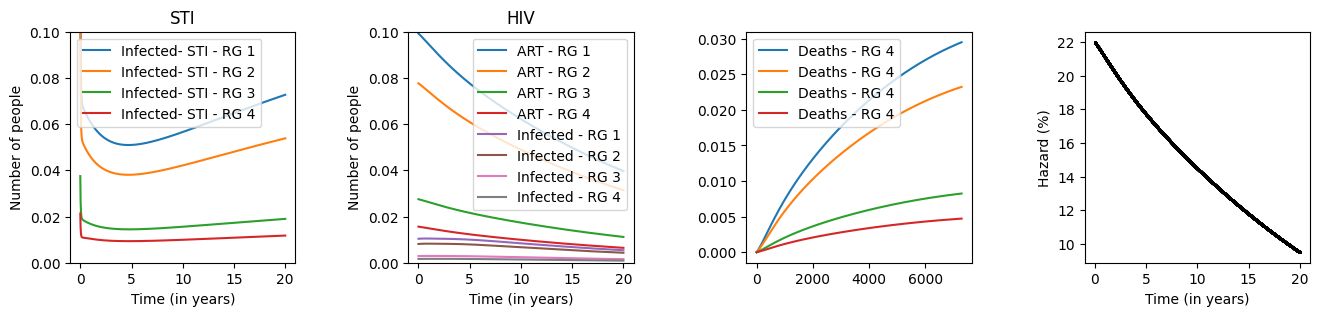

In [5]:

fig, axes = plt.subplots(1, 4, figsize=(16,3))
fig.subplots_adjust(wspace=0.5)

def number_of_people(comps, risk_group):
    total = 0
    for comp in comps:
        total += output.ys[comp][:,risk_group]
    return total

# STI
ax = axes[0]
for i in range(output.ys["Is_STI"].shape[1]):
    ax.plot(number_of_people(comps=("Is_STI", "Ia_STI"), risk_group=i), label="Infected- STI - RG "+str(i+1))

ax.set_xticks(np.arange(0, 365*20+1, 365*5))
ax.set_xticklabels(np.arange(0, 21, 5))
ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("STI")
ax.legend()

# HIV
ax = axes[1]
# ART per risk group
for i in range(output.ys["A1"].shape[1]): # go through all risk groups
    ax.plot(number_of_people(comps=("A1", "A2", "A3", "A4"), risk_group=i), label="ART - RG "+str(i+1)) # add all disease stages together

# I per risk group 
for i in range(output.ys["I1"].shape[1]):
    ax.plot(number_of_people(comps=("IP", "I1", "I2", "I3", "I4"), risk_group=i), label="Infected - RG "+str(i+1))


ax.set_xticks(np.arange(0, 365*20+1, 365*5))
ax.set_xticklabels(np.arange(0, 21, 5))
ax.set_ylim(0, 0.1)
ax.set_ylabel("Number of people")
ax.set_xlabel("Time (in years)")
ax.set_title("HIV")
ax.legend()

# HIV deaths
ax = axes[2]
ax.plot(output.ys["D"], label="Deaths - RG "+str(i+1))
ax.legend()

# hazard
ax = axes[3]
all_ART_keys = ["A1","A2","A3","A4"]
all_HIV_keys = ["S","SP","I1","I2","I3","I4","IP"] + all_ART_keys
all_STI_keys = ["S_STI","Ia_STI","Is_STI","T_STI"]
sum_vector = 0
compartment_matrix = 0
for i in range(output.ys["A1"].shape[1]):
    sum_vector += jnp.sum(jnp.array([output.ys[k][:,i] for k in all_HIV_keys]), axis=0)

for i in range(output.ys["A1"].shape[1]):
    compartment_matrix += jnp.sum(jnp.array([output.ys[key][:,i] for key in all_ART_keys]), axis=0)  # Shape: (len(all_ART_keys), time_points)
hazard_vector = compartment_matrix / sum_vector * 100   # Vectorized hazard computation

# Plot all points at once
ax.scatter(range(len(hazard_vector)), hazard_vector, color="black", s=1)

ax.set_xticks(np.arange(0, 365*20+1, 365*5))
ax.set_xticklabels(np.arange(0, 21, 5))
ax.set_ylabel("Hazard (%)")
ax.set_xlabel("Time (in years)")

# print for each compartment in output the last time value
HIV_sum_at_end = [0,0,0,0]
STI_sum_at_end = [0,0,0,0]
HIV_sum_at_start = [0,0,0,0]
STI_sum_at_start = [0,0,0,0]

for key, value in output.ys.items():
    print(key, value[-1])

for key in (all_HIV_keys + ["D"]):
    for i in range(4):
        HIV_sum_at_end[i] += output.ys[key][-1,i]
        HIV_sum_at_start[i] += output.ys[key][0,i]
for key in (all_STI_keys + ["D_STI"]):
    for i in range(4):
        STI_sum_at_end[i] += output.ys[key][-1,i]
        STI_sum_at_start[i] += output.ys[key][0,i]
print("HIV sum at start", HIV_sum_at_start)
print("STI sum at start", STI_sum_at_start)
print("HIV sum at end", HIV_sum_at_end)
print("STI sum at end", STI_sum_at_end)

In [ ]:

#plt.plot(output.ys["S1_STI"]+output.ys["S2_STI"]+output.ys["S3_STI"]+output.ys["S4_STI"], label="Susceptible - STI")
#plt.plot(output.ys["Is1_STI"]+output.ys["Is2_STI"]+output.ys["Is3_STI"]+output.ys["Is4_STI"], label="Infected(Symptomatic) - STI")
#plt.plot(output.ys["Ia1_STI"]+output.ys["Ia2_STI"]+output.ys["Ia3_STI"]+output.ys["Ia4_STI"], label="Infected(Asymptomatic) - STI")
#plt.plot(output.ys["T1_STI"]+output.ys["T2_STI"]+output.ys["T3_STI"]+output.ys["T4_STI"], label="Treated - STI")
# plot infected by risk group
plt.plot(output.ys["Is1_STI"]+output.ys["Ia1_STI"], label="Infected- STI - Risk Group 1")
plt.plot(output.ys["Is2_STI"]+output.ys["Ia2_STI"] , label="Infected- STI - Risk Group 2")
plt.plot(output.ys["Is3_STI"]+output.ys["Ia3_STI"], label="Infected- STI - Risk Group 3")
plt.plot(output.ys["Is4_STI"]+output.ys["Ia4_STI"], label="Infected- STI - Risk Group 4")
#plt.yscale('log')
plt.legend()



In [ ]:
# plot HIV

plt.figure()
#plt.plot(output.ys["S1"]+output.ys["SP1"]+output.ys["S2"]+output.ys["SP2"]+output.ys["S3"]+output.ys["SP3"]+output.ys["S4"]+output.ys["SP4"], label="Susceptible - HIV")
#plt.plot(output.ys["I11"]+output.ys["IP11"]+output.ys["I12"]+output.ys["I13"]+output.ys["I14"]+output.ys["I21"]+output.ys["IP21"]+output.ys["I22"]+output.ys["I23"]+output.ys["I24"]+output.ys["I31"]+output.ys["IP31"]+output.ys["I32"]+output.ys["I33"]+output.ys["I34"]+output.ys["I41"]+output.ys["IP41"]+output.ys["I42"]+output.ys["I43"]+output.ys["I44"], label="Infected - HIV")
#plt.plot(output.ys["A11"]+output.ys["A12"]+output.ys["A13"]+output.ys["A14"]+output.ys["A21"]+output.ys["A22"]+output.ys["A23"]+output.ys["A24"]+output.ys["A31"]+output.ys["A32"]+output.ys["A33"]+output.ys["A34"]+output.ys["A41"]+output.ys["A42"]+output.ys["A43"]+output.ys["A44"], label="ART - HIV")
# A per risk group in different shades of blue
plt.plot(output.ys["A11"]+output.ys["A12"]+output.ys["A13"]+output.ys["A14"], label="ART - Risk group 1", color="blue")
plt.plot(output.ys["A21"]+output.ys["A22"]+output.ys["A23"]+output.ys["A24"], label="ART - Risk group 2", color="steelblue")
plt.plot(output.ys["A31"]+output.ys["A32"]+output.ys["A33"]+output.ys["A34"], label="ART - Risk group 3", color="lightblue")
plt.plot(output.ys["A41"]+output.ys["A42"]+output.ys["A43"]+output.ys["A44"], label="ART - Risk group 4", color="navy")
# I per risk group in different shades of red
plt.plot(output.ys["I11"]+output.ys["IP11"]+output.ys["I12"]+output.ys["I13"]+output.ys["I14"], label="Infected - Risk group 1", color="red")
plt.plot(output.ys["I21"]+output.ys["IP21"]+output.ys["I22"]+output.ys["I23"]+output.ys["I24"], label="Infected - Risk group 2", color="darkred")
plt.plot(output.ys["I31"]+output.ys["IP31"]+output.ys["I32"]+output.ys["I33"]+output.ys["I34"], label="Infected - Risk group 3", color="lightcoral")
plt.plot(output.ys["I41"]+output.ys["IP41"]+output.ys["I42"]+output.ys["I43"]+output.ys["I44"], label="Infected - Risk group 4", color="hotpink")
plt.legend()
I_comps = ["I11", "I12", "I13", "I14", "I21", "I22", "I23", "I24", "I31", "I32", "I33", "I34", "I41", "I42", "I43", "I44"]
A_comps = ["A11", "A12", "A13", "A14", "A21", "A22", "A23", "A24", "A31", "A32", "A33", "A34", "A41", "A42", "A43", "A44"]
S_comps = ["S1", "SP1", "S2", "SP2", "S3", "SP3", "S4", "SP4"]



In [ ]:
["I1", "I2", "I3", "I4", "D"][:-1]